In [1]:
import pandas as pd

ddata = pd.read_csv("./data/ddata.txt", encoding="euc-kr", sep="\t", names=["num","speaker","contents","tags"])
mdata = pd.read_csv("./data/mdata.txt", encoding="euc-kr", sep="\t", names=["id","part","category","exptype","exp"])

ddata.head()

,num,speaker,contents,tags
0,0,<CO>,어서오세요. 코디봇입니다. 무엇을 도와드릴까요?,INTRO
1,1,<US>,처음 대학교 들어가는데 입을 옷 코디해주세요.,NaN
2,2,<CO>,신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요.,EXP_RES_SITUATION;EXP_RES_DESCRIPTION
3,3,<AC>,SW-009,NaN
4,4,<US>,이 옷에 어울리는 치마로 추천해주세요.,USER_SUCCESS


# 1. 전체 대화셋 개수 카운트

In [2]:
dial_num = 0

for i in range(1, len(ddata)):
    if ddata.loc[i, "num"] == 0:
        dial_num += 1
print("총 대화셋 수: ",dial_num)

총 대화셋 수:  7235


# 2. Mdata 합치기

## - Part 살려서 합치기

In [3]:
c_mdata = pd.DataFrame({"id":[0],"exp":[None]})
c_mdata.drop(0, axis=0, inplace=True)
c_mdata

,id,exp


In [4]:
id = ""
idx = 0
for i in range(len(mdata)):
    if id == mdata.loc[i, "id"]:
        c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] = c_mdata.loc[c_mdata.index[(c_mdata["id"] == id)].tolist().pop(),"exp"] + " " + mdata.loc[i, "exp"]
    
    else:
        id = mdata.loc[i, "id"]
        c_mdata.loc[i, "id"] = id
        c_mdata.loc[i, "exp"] = mdata.loc[i, "exp"]

c_mdata.head()

,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
20,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
38,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
63,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
84,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


In [5]:
for i in range(len(c_mdata)): # id 뒤에 공백 없애기
    c_mdata.iloc[i].id = c_mdata.iloc[i].id.strip()

print(c_mdata.iloc[0].id)
c_mdata.reset_index(drop=True,inplace=True)
c_mdata.head()

BL-001


,id,exp
0,BL-001,단추 여밈의 전체 오픈형 스탠드 칼라와 브이넥 네크라인의 결합스타일 손목까지 내려오...
1,BL-002,넓은 셔츠칼라 네크라인 앞중심에 반 오픈 끈여밈있는 스타일 드롭숄더 퍼프형 소매로 ...
2,BL-003,앞 중심에 단추 여밈 칼라가 없는 넓고 깊게 파인 브이넥 엉덩이 밑으로 내려오는 긴...
3,BL-004,"앞중심에 단추 여밈 칼라가 없는 라운드넥으로 골반 위에서 끝나는 짧은 기장 손목, ..."
4,BL-005,앞단추 여밈의 전체 오픈형 칼라가 없는 라운드넥크라인 엉덩이 위에서 끝나는 짧은 기...


# 3. NaN, Null 값 확인

In [6]:
ddata.drop(ddata.index[ddata.tags == "INTRO"].tolist(), axis=0, inplace=True)
ddata.reset_index(drop=True, inplace=True)
ddata[ddata.tags == "INTRO"]

,num,speaker,contents,tags


In [7]:
ddata.isnull().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [8]:
ddata.isna().sum()

num             0
speaker         0
contents        0
tags        51927
dtype: int64

In [9]:
ddata.fillna("", inplace=True)
ddata.isna().sum()

num         0
speaker     0
contents    0
tags        0
dtype: int64

In [10]:
mdata.isnull().sum()

id          0
part        0
category    0
exptype     0
exp         0
dtype: int64

In [11]:
c_mdata.isnull().sum()

id     0
exp    0
dtype: int64

# 4. 추천 성공 의상 아이디 종류 및 빈도 카운트 

## 한 번에 추천해도 실패하면 전부 실패로 달기

In [12]:
c_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
c_data.drop(0,axis=0,inplace=True)
c_data.head()

,contents,id


<코드 동작 원리>
<br>

대화문 하나씩 받아온 다음
- AC 태그 문장이면 일단 의상 변수에 저장,
- user_success 태그 문장이면

   - 변수에 저장된 의상이 하나면

      - 바로 대화문 변수랑 의상 변수 및 의상 메타데이터 합쳐서 저장 -> 레이블(id 컬럼에 저장)은 의상 코드가 됨

   - 변수에 저장된 의상의 여러 개면

      - 의상을 하나의 코드 단위로 쪼개서 대화문 변수랑 의상 메타데이터 합쳐서 저장
      
-  둘 다 아니고 일반 대화문이면 대화문 변수에 저장

In [13]:
dial = ddata.loc[0, "contents"].strip()
ac = ""

for i in range(1,len(ddata)):
    cur_sen = ddata.loc[i,"contents"].strip()

    if ddata.loc[i, "num"] > ddata.loc[i-1, "num"]: # 이전 대화셋에 포함된 문장인지 확인
        
        if ddata.loc[i,"speaker"] == "<AC>": # case 1. 의상 아이디가 나온 경우
            if len(ac) > 1:
                ac = ac + " " + cur_sen # 의상 아이디 저장
            else:
                ac = cur_sen

        elif "USER_SUCCESS" == ddata.loc[i,"tags"]: # case 2. USER_SUCCESS 태그가 나온 경우
            if 0 < len(ac) < 7: # 의상을 하나만 추천한 경우
                dial = dial + " " + ac + " " + cur_sen
                c_data.loc[i, "contents"] =  dial + " " + c_mdata.loc[c_mdata.id == ac].exp.values[0]
                c_data.loc[i, "id"] = ac
                ac = ""

            elif len(ac) == 0:
                dial = dial + " " + cur_sen

            else: # 의상을 한 번에 여러 개 추천한 경우
                idx_cnt = 0
                for one_ac in ac.split():
                    c_data.loc[i + idx_cnt, "contents"] =  dial + " " + one_ac + " "+ cur_sen + " " + c_mdata.loc[c_mdata.id == one_ac].exp.values[0]
                    c_data.loc[i + idx_cnt, "id"] = one_ac
                    idx_cnt += 1
                dial = dial + " " + ac + " " + cur_sen    
                ac = ""
        
        elif "USER_FAIL" in ddata.loc[i,"tags"]:
            dial = dial + " " + ac + " " + cur_sen
            ac = ""

        else: # case 3. 그냥 대화문인 경우
            dial = dial + " " + cur_sen
    
    else: #새로운 대화셋 시작이면 초기화
        dial = cur_sen
        ac = ""

In [14]:
print("전체 데이터 수: ", len(c_data))
c_data.head()

전체 데이터 수:  34303


,contents,id
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
12,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
17,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
22,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
26,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [15]:
c_data.reset_index(drop=True ,inplace=True)
c_data.head()

,contents,id
0,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SW-009
1,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SK-053
2,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019
3,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,SE-039
4,처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터...,CT-019


In [16]:
c_data.loc[0].contents

'처음 대학교 들어가는데 입을 옷 코디해주세요. 신입생 코디에 어울리게 화사한 스웨터를 추천해드릴게요. SW-009 이 옷에 어울리는 치마로 추천해주세요. 라운드 네크라인 여밈이 없는 풀오버 스타일 전체 케이블 조직 드롭숄더 슬리브 손등까지 오는 길이의 소매 몸에 적당히 맞는 품 엉덩이를 살짝 덮는 길이 네크라인, 소매 끝, 밑단에 고무단 처리 레이온52%,나일론20%,폴리에스터28% 꽈배기 조직, 플레인 조직이 섞여 있는 형태 드라이 크리닝 단색의 라임색 브라이트톤(고명도 고채도)의 옐로우 그린 산뜻하고 발랄한 느낌 기본의 단정한 편안한 산뜻한 발랄한 경쾌한 따뜻한 데일리룩 캠퍼스룩'

In [17]:
vt_data = pd.DataFrame({"contents":[None], "id":["xx-xxx"]})
vt_data.drop(0,axis=0,inplace=True)
vt_data.head()

,contents,id


In [18]:
for i in range(len(c_data)):
    if "VT" in c_data["id"][i][0:2]:
        vt_data = vt_data.append(c_data.iloc[i])

vt_data.reset_index(drop=True, inplace=True)
print("데이터 개수",len(vt_data))
vt_data.head()

데이터 개수 272


,contents,id
0,크리스마스에 소개팅 할 거예요. 귀여워보이는 옷으로 주세요. 네. 잠시만 기다려주세...,VT-029
1,"면접 때 입을만한 오피스룩을 찾고 있는데, 단정하면서도 세련된 오피스룩이 있을까요?...",VT-021
2,"면접 때 입을만한 오피스룩을 찾고 있는데, 단정하면서도 세련된 오피스룩이 있을까요?...",VT-021
3,지역 꽃축제에 진행을 맡게 되었어요. 나이에 맞는 깔끔한 옷을 원해요. 깔끔한 스커...,VT-024
4,이번 주말에 자전거 타러 갈 때 입을 옷 추천바랍니다. 활동하시기에 부담 없이 편안...,VT-004


In [19]:
vt_data["contents"] = vt_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
vt_data.head()

<ipython-input-19-58d1bec83174>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  vt_data["contents"] = vt_data["contents"].str.replace("[^A-Za-z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,contents,id
0,크리스마스에 소개팅 할 거예요 귀여워보이는 옷으로 주세요 네 잠시만 기다려주세요 핑...,VT-029
1,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,VT-021
2,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,VT-021
3,지역 꽃축제에 진행을 맡게 되었어요 나이에 맞는 깔끔한 옷을 원해요 깔끔한 스커트에...,VT-024
4,이번 주말에 자전거 타러 갈 때 입을 옷 추천바랍니다 활동하시기에 부담 없이 편안한...,VT-004


In [20]:
vt_data["id"] = vt_data["id"].str.replace("[^0-9]","")

vt_data.head()

<ipython-input-20-cc1cdf373f86>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  vt_data["id"] = vt_data["id"].str.replace("[^0-9]","")


,contents,id
0,크리스마스에 소개팅 할 거예요 귀여워보이는 옷으로 주세요 네 잠시만 기다려주세요 핑...,029
1,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,021
2,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,021
3,지역 꽃축제에 진행을 맡게 되었어요 나이에 맞는 깔끔한 옷을 원해요 깔끔한 스커트에...,024
4,이번 주말에 자전거 타러 갈 때 입을 옷 추천바랍니다 활동하시기에 부담 없이 편안한...,004


In [21]:
from collections import Counter
temp = vt_data["id"].tolist()
type_count = dict(Counter(temp))
type_count

{'029': 15,
 '021': 10,
 '024': 3,
 '004': 16,
 '023': 10,
 '030': 4,
 '022': 1,
 '002': 7,
 '018': 5,
 '003': 2,
 '014': 4,
 '012': 4,
 '015': 4,
 '001': 7,
 '031': 2,
 '026': 7,
 '010': 9,
 '009': 5,
 '017': 4,
 '020': 4,
 '008': 5,
 '007': 2,
 '027': 2,
 '005': 3,
 '013': 2,
 '028': 1,
 '006': 1,
 '025': 1,
 '061': 10,
 '051': 12,
 '034': 2,
 '056': 12,
 '046': 1,
 '037': 2,
 '059': 4,
 '042': 4,
 '055': 4,
 '058': 1,
 '050': 1,
 '035': 4,
 '060': 3,
 '039': 5,
 '064': 2,
 '072': 4,
 '103': 2,
 '052': 2,
 '063': 4,
 '084': 1,
 '105': 1,
 '067': 7,
 '076': 2,
 '109': 5,
 '077': 3,
 '065': 3,
 '111': 4,
 '075': 3,
 '019': 2,
 '085': 1,
 '094': 1,
 '106': 3,
 '066': 1,
 '016': 4,
 '068': 2,
 '057': 2,
 '093': 2,
 '062': 1,
 '011': 1,
 '104': 1,
 '033': 1,
 '107': 1,
 '080': 1}

In [22]:
len(type_count)

71

In [23]:
del_list = []
for i in type_count.keys():
    if type_count.get(i) == 1:
        del_list.append(i)
del_list

['022',
 '028',
 '006',
 '025',
 '046',
 '058',
 '050',
 '084',
 '105',
 '085',
 '094',
 '066',
 '062',
 '011',
 '104',
 '033',
 '107',
 '080']

In [24]:
vt_data.head()

,contents,id
0,크리스마스에 소개팅 할 거예요 귀여워보이는 옷으로 주세요 네 잠시만 기다려주세요 핑...,029
1,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,021
2,면접 때 입을만한 오피스룩을 찾고 있는데 단정하면서도 세련된 오피스룩이 있을까요 상...,021
3,지역 꽃축제에 진행을 맡게 되었어요 나이에 맞는 깔끔한 옷을 원해요 깔끔한 스커트에...,024
4,이번 주말에 자전거 타러 갈 때 입을 옷 추천바랍니다 활동하시기에 부담 없이 편안한...,004


In [25]:
for i in del_list:
    vt_data = vt_data[vt_data["id"] != i]

In [26]:
len(vt_data)

254

In [27]:
vt_data.reset_index(drop=True, inplace=True)

In [28]:
import matplotlib.pyplot as plt
plt.bar(Counter(vt_data.id).keys(),Counter(vt_data.id).values(), color='k')

<BarContainer object of 53 artists>

# 5. 형태소 분석

## Mecab 사용

In [29]:
from konlpy.tag import Mecab
mecab = Mecab()

In [30]:
mecab.morphs(vt_data["contents"][0])

['크리스마스',
 '에',
 '소개팅',
 '할',
 '거',
 '예요',
 '귀여워',
 '보이',
 '는',
 '옷',
 '으로',
 '주세요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '핑크',
 '색',
 '의',
 '귀여운',
 '코트',
 '가',
 '포함',
 '된',
 '코디',
 '입니다',
 'CT',
 '052',
 'SW',
 '050',
 'PT',
 '037',
 'SE',
 '029',
 '리본',
 '이',
 '있',
 '는',
 '셔츠',
 '는',
 '없',
 '나요',
 '니트',
 '랑',
 '셔츠',
 '를',
 '레이어드',
 '하',
 '고',
 '싶',
 '은데요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '이',
 '있',
 '는',
 '셔츠',
 '와',
 '니트',
 '조끼',
 '를',
 '추천',
 '해',
 '드립니다',
 '전',
 '에',
 '보여',
 '주',
 '신',
 '니트',
 '에',
 '레이어드',
 '할',
 '셔츠',
 '를',
 '보여',
 '주',
 '세요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '이',
 '있',
 '는',
 '하얀색',
 '의',
 '셔츠',
 '는',
 '어떠신가요',
 'VT',
 '029',
 '좋',
 '습니다',
 '이',
 '셔츠',
 '와',
 '니트로',
 '할게요',
 '니',
 '크',
 '조끼',
 'V',
 '네크라인',
 '베스트',
 '여',
 '밈',
 '없',
 '는',
 '풀오버',
 '스타일',
 '드롭',
 '숄더',
 '형태',
 '전체',
 '적',
 '으로',
 '넉넉',
 '한',
 '품',
 '뒤',
 '가',
 '앞',
 '보다',
 '더',
 '긴',
 '언',
 '발란스',
 '형태',
 '앞',
 '은',
 '골반',
 '까지',
 '오',
 '고',
 '뒤',
 '는',
 '엉덩이',

In [31]:
len(vt_data)

254

In [32]:
x_data = []
for i in range(len(vt_data)):
    x_data.append(mecab.morphs(vt_data["contents"][i]))

x_data[0]

['크리스마스',
 '에',
 '소개팅',
 '할',
 '거',
 '예요',
 '귀여워',
 '보이',
 '는',
 '옷',
 '으로',
 '주세요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '핑크',
 '색',
 '의',
 '귀여운',
 '코트',
 '가',
 '포함',
 '된',
 '코디',
 '입니다',
 'CT',
 '052',
 'SW',
 '050',
 'PT',
 '037',
 'SE',
 '029',
 '리본',
 '이',
 '있',
 '는',
 '셔츠',
 '는',
 '없',
 '나요',
 '니트',
 '랑',
 '셔츠',
 '를',
 '레이어드',
 '하',
 '고',
 '싶',
 '은데요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '이',
 '있',
 '는',
 '셔츠',
 '와',
 '니트',
 '조끼',
 '를',
 '추천',
 '해',
 '드립니다',
 '전',
 '에',
 '보여',
 '주',
 '신',
 '니트',
 '에',
 '레이어드',
 '할',
 '셔츠',
 '를',
 '보여',
 '주',
 '세요',
 '네',
 '잠시',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '이',
 '있',
 '는',
 '하얀색',
 '의',
 '셔츠',
 '는',
 '어떠신가요',
 'VT',
 '029',
 '좋',
 '습니다',
 '이',
 '셔츠',
 '와',
 '니트로',
 '할게요',
 '니',
 '크',
 '조끼',
 'V',
 '네크라인',
 '베스트',
 '여',
 '밈',
 '없',
 '는',
 '풀오버',
 '스타일',
 '드롭',
 '숄더',
 '형태',
 '전체',
 '적',
 '으로',
 '넉넉',
 '한',
 '품',
 '뒤',
 '가',
 '앞',
 '보다',
 '더',
 '긴',
 '언',
 '발란스',
 '형태',
 '앞',
 '은',
 '골반',
 '까지',
 '오',
 '고',
 '뒤',
 '는',
 '엉덩이',

In [33]:
stopwords = []
with open('./data/불용어사전.txt', mode='rt', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        stopwords.append(word)
stopwords[0:2]

['어찌됐든', '그위에']

In [34]:
X_data = []
for sentence in x_data: #문장 하나 가져오고 단어 단위로 쪼개기
    temp_X = [word for word in sentence if not word in stopwords] # 불용어 제거
    X_data.append(temp_X)
X_data[0]

['크리스마스',
 '소개팅',
 '거',
 '예요',
 '귀여워',
 '보이',
 '옷',
 '주세요',
 '만',
 '기다려',
 '주',
 '세요',
 '핑크',
 '색',
 '귀여운',
 '코트',
 '포함',
 '된',
 '코디',
 '입니다',
 'CT',
 '052',
 'SW',
 '050',
 'PT',
 '037',
 'SE',
 '029',
 '리본',
 '있',
 '셔츠',
 '나요',
 '니트',
 '랑',
 '셔츠',
 '레이어드',
 '고',
 '싶',
 '은데요',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '있',
 '셔츠',
 '니트',
 '조끼',
 '추천',
 '드립니다',
 '전',
 '보여',
 '주',
 '신',
 '니트',
 '레이어드',
 '셔츠',
 '보여',
 '주',
 '세요',
 '만',
 '기다려',
 '주',
 '세요',
 '리본',
 '있',
 '하얀색',
 '셔츠',
 '어떠신가요',
 'VT',
 '029',
 '좋',
 '셔츠',
 '니트로',
 '할게요',
 '니',
 '크',
 '조끼',
 'V',
 '네크라인',
 '베스트',
 '밈',
 '풀오버',
 '스타일',
 '드롭',
 '숄더',
 '형태',
 '전체',
 '적',
 '넉넉',
 '품',
 '뒤',
 '앞',
 '보다',
 '더',
 '긴',
 '언',
 '발란스',
 '형태',
 '앞',
 '골반',
 '고',
 '뒤',
 '엉덩이',
 '덮',
 '길',
 '네크라인',
 '끝',
 '밑단',
 'RIB',
 '처리',
 '몸통',
 '옆',
 '선',
 '트임',
 '있',
 '아크릴',
 '75',
 '나일론',
 '10',
 '레이온',
 '10',
 '울',
 '5',
 '플레인',
 '조직',
 '울',
 '함유',
 '보온성',
 '높여줌',
 '비침',
 '활동',
 '편안',
 '함',
 '드라이',
 '크리',
 '닝',
 '연한',
 '베이지',
 '블루',
 '그레이',
 '브라운',
 '컬

## 1. 임베딩 레이어 활용

### 정수 인코딩

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

In [36]:
threshold = 6
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1894
등장 빈도가 5번 이하인 희귀 단어의 수: 1059
단어 집합에서 희귀 단어의 비율: 55.91341077085533
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.767415518217859


In [37]:
vocab_size = total_cnt - rare_cnt + 1 # tokenizer 함수에 들어 갈 때 영향줘서 1 추가 해야 됨
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 836


케라스 토크나이저의 정수 인코딩은 인덱스가 1부터 시작하지만,

케라스 원-핫 인코딩에서 배열의 인덱스가 0부터 시작하기 때문에

배열의 크기를 실제 단어 집합의 크기보다 +1로 생성해야하므로 미리 +1 선언 

### 맨 앞자리는 비어있어야 함 (원 핫 인코딩은 정수 인코딩한 뒤 나오는 정수 값 자리에 1을 넣는 것)

In [38]:
tokenizer = Tokenizer(num_words=vocab_size - 1)
tokenizer.fit_on_texts(X_data)
len(tokenizer.word_index)

1894

In [39]:
X_data = tokenizer.texts_to_sequences(X_data) # 단어에 정수 붙여줄 때 num_word 적용

위에서 num_words는 이 데이터에서 등장 빈도 순위로 몇 번째에 해당하는 단어까지만 사용할 것인지 조절

예를 들어서 100이란 값을 넣으면, 등장 빈도 순위가 1~100에 해당하는 단어만 사용

In [40]:
X_data[1]

[520,
 10,
 7,
 500,
 106,
 227,
 19,
 4,
 92,
 152,
 85,
 39,
 237,
 36,
 500,
 106,
 4,
 333,
 776,
 411,
 5,
 120,
 33,
 7,
 9,
 1,
 2,
 438,
 371,
 71,
 557,
 45,
 4,
 31,
 500,
 106,
 5,
 120,
 158,
 13,
 6,
 17,
 22,
 11,
 439,
 259,
 777,
 162,
 346,
 29,
 584,
 121,
 260,
 426,
 159,
 3,
 33,
 13,
 81,
 79,
 23,
 5,
 192,
 159,
 176,
 42,
 1,
 2,
 520,
 347,
 24,
 121,
 176,
 5,
 120,
 158,
 13,
 24,
 54,
 121,
 277,
 270,
 47,
 520,
 83,
 88,
 115,
 244,
 76,
 227,
 1,
 2,
 323,
 17,
 244,
 76,
 372,
 120,
 158,
 13,
 28,
 32,
 249,
 23,
 520,
 776,
 132,
 241,
 27,
 253,
 54,
 142,
 49,
 8,
 28,
 120,
 19,
 178,
 13,
 6,
 17,
 22,
 11,
 373,
 520,
 49,
 778,
 26,
 8,
 126,
 25,
 16,
 16,
 27,
 585,
 56,
 20,
 127,
 90,
 56,
 20,
 52,
 55,
 38,
 214,
 52,
 144,
 55,
 53,
 60,
 138,
 183,
 91,
 59,
 99,
 40,
 90,
 56,
 20,
 296,
 586,
 205,
 481,
 12,
 587,
 36,
 78,
 26,
 98,
 82,
 63,
 34,
 3,
 46,
 324,
 153,
 154,
 84,
 588,
 440,
 261,
 1,
 296,
 398,
 374,
 39,
 125,
 43,

문장 최대 길이 : 292
문장의 평균 길이 : 157.18897637795277


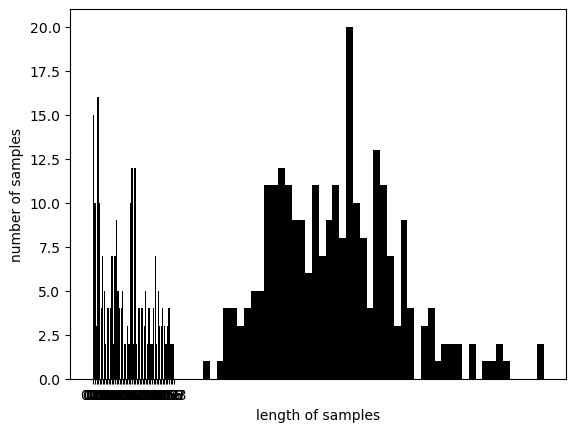

In [41]:
print('문장 최대 길이 :',max(len(l) for l in X_data))
print('문장의 평균 길이 :',sum(map(len, X_data))/len(X_data))
plt.hist([len(s) for s in X_data], bins=50, color='k')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
plt.close()

In [42]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 300
below_threshold_len(max_len, X_data)

전체 샘플 중 길이가 300 이하인 샘플의 비율: 100.0


## padding

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_data = pad_sequences(X_data, maxlen = max_len)

In [44]:
print(len(X_data[1]))
X_data[1]

300


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 520,  10,   7, 500,
       106, 227,  19,   4,  92, 152,  85,  39, 237,  36, 500, 106,   4,
       333, 776, 411,   5, 120,  33,   7,   9,   1,   2, 438, 371,  71,
       557,  45,   4,  31, 500, 106,   5, 120, 158,  13,   6,  17,  22,
        11, 439, 259, 777, 162, 346,  29, 584, 121, 260, 426, 159,   3,
        33,  13,  81,  79,  23,   5, 192, 159, 176,  42,   1,   2, 520,
       347,  24, 121, 176,   5, 120, 158,  13,  24,  54, 121, 27

# 6. LSTM 돌리기 

In [45]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [46]:
X = X_data
y = vt_data.id.tolist()

In [47]:
X[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 520,  10,   7, 500,
       106, 227,  19,   4,  92, 152,  85,  39, 237,  36, 500, 106,   4,
       333, 776, 411,   5, 120,  33,   7,   9,   1,   2, 438, 371,  71,
       557,  45,   4,  31, 500, 106,   5, 120, 158,  13,   6,  17,  22,
        11, 439, 259, 777, 162, 346,  29, 584, 121, 260, 426, 159,   3,
        33,  13,  81,  79,  23,   5, 192, 159, 176,  42,   1,   2, 520,
       347,  24, 121, 176,   5, 120, 158,  13,  24,  54, 121, 27

In [48]:
y[1]

'021'

In [49]:
print(len(X),len(y))

254 254


In [50]:
y = to_categorical(y)

In [51]:
print(X.shape, y.shape)

(254, 300) (254, 112)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=777, stratify=y) #추천 한 번밖에 안된 애들 있어서 stratify 안됨

In [53]:
num_class = int(max(vt_data.id)) + 1

In [67]:
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

In [72]:
model = Sequential()
model.add(Embedding(vocab_size, max_len))
model.add(SimpleRNN(max_len))
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         250800    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 300)               180300    
_________________________________________________________________
dense_4 (Dense)              (None, 112)               33712     
Total params: 464,812
Trainable params: 464,812
Non-trainable params: 0
_________________________________________________________________


In [73]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('vt_model_rnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [74]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

print("테스트 셋 체크")
loaded_model = load_model('vt_model_rnn.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

Epoch 1/10
5/5 [==============================] - 4s 560ms/step - loss: 4.2448 - acc: 0.3391 - val_loss: 3.4729 - val_acc: 0.6389

Epoch 00001: val_acc improved from -inf to 0.63889, saving model to vt_model_rnn.h5
Epoch 2/10
5/5 [==============================] - 2s 428ms/step - loss: 2.5803 - acc: 0.9379 - val_loss: 2.7185 - val_acc: 0.7778

Epoch 00002: val_acc improved from 0.63889 to 0.77778, saving model to vt_model_rnn.h5
Epoch 3/10
5/5 [==============================] - 2s 419ms/step - loss: 1.6230 - acc: 0.9868 - val_loss: 2.3267 - val_acc: 0.8056

Epoch 00003: val_acc improved from 0.77778 to 0.80556, saving model to vt_model_rnn.h5
Epoch 4/10
5/5 [==============================] - 2s 454ms/step - loss: 1.1334 - acc: 0.9920 - val_loss: 1.9276 - val_acc: 0.8056

Epoch 00004: val_acc did not improve from 0.80556
Epoch 5/10
5/5 [==============================] - 2s 353ms/step - loss: 0.8115 - acc: 1.0000 - val_loss: 1.6526 - val_acc: 0.8056

Epoch 00005: val_acc did not improve 

Cannot convert a symbolic Tensor -> numpy 버전 1.19.5로 바꿔줌

https://wikidocs.net/45101

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


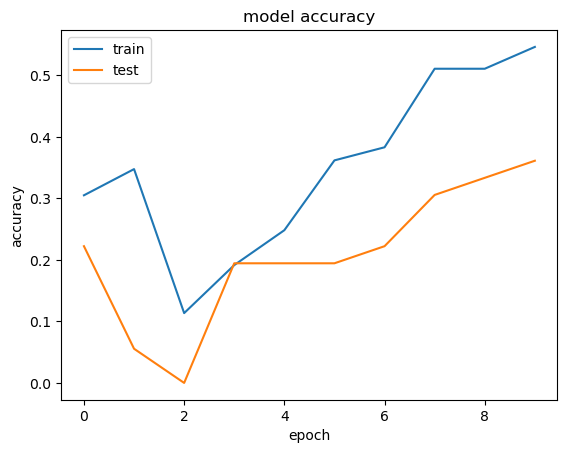

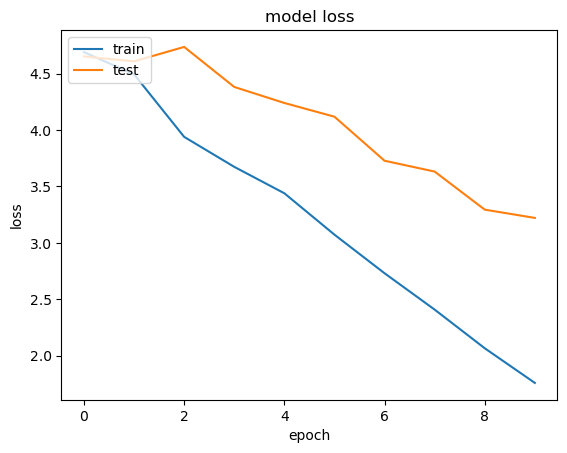

In [58]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()